# Wind power time series from ERA5 hourly wind speed data
https://cds.climate.copernicus.eu/live/queue

Efficient downloading: https://cds.climate.copernicus.eu/toolbox/doc/how-to/4_how_to_use_output_widgets/4_how_to_use_output_widgets.html#output-ct-output-download

4 wind variables, 1 location (4 lat/lon), 2 years => ca 30 min request running time


In [3]:
%load_ext autoreload
%autoreload 2
%env ECCODES_DEFINITION_PATH=C:download_era5_datasers/hsven/Miniconda3/envs/timeseries/Library/share/eccodes/definitions

import utils
import pandas as pd
from pathlib import Path
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: ECCODES_DEFINITION_PATH=C:download_era5_datasers/hsven/Miniconda3/envs/timeseries/Library/share/eccodes/definitions


In [26]:
powercurves = pd.read_csv("../ncep_reanalysis/wind_powercurves_tradewind.csv",index_col=0)

In [136]:
locations = pd.DataFrame.from_dict({
    "smøla": {"lat":63.407, "lon":7.924, "power_curve":"offshore", "wind_scaling":1.0},
    "tonstad": {"lat":58.5316, "lon":6.7928, "power_curve":"offshore", "wind_scaling":1.0},
},orient="index")

In [139]:
# Download data for 2 specific locations for 2 years:
# 50 min per year (9 variables, 9.2 MB)
locations3 = utils.download_era5_data(locations,[2020,2021],data_path=Path("./data2"),replace_existing=False)
logging.info("Done")

2022-03-03 08:55:53,664 WARNING Ignoring index file 'C:\\Users\\hsven\\code\\energy_timeseries\\era5\\data2\\era5_atm_grid.grib.90c91.idx' incompatible with GRIB file
2022-03-03 08:55:53,979 INFO smøla: Data file: data2\era5data_lat=63.5_lon=8.0_year=2020.grib
2022-03-03 08:55:53,980 INFO Downloading data to: data2\era5data_lat=63.5_lon=8.0_year=2020.grib
2022-03-03 08:55:54,135 INFO Welcome to the CDS
2022-03-03 08:55:54,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-03-03 08:55:54,202 INFO Request is queued
2022-03-03 08:58:45,951 INFO Request is running
2022-03-03 09:50:17,385 INFO Request is completed
2022-03-03 09:50:17,387 INFO Downloading https://download-0003.copernicus-climate.eu/cache-compute-0003/cache/data8/adaptor.mars.internal-1646294321.5640824-11369-14-eadab288-4169-4268-9e70-6d10ad7118d2.grib to data2\era5data_lat=63.5_lon=8.0_year=2020.grib (9M)
2022-03-03 09:50:19,919 INFO Download rate 3.6M/s        

In [9]:
# Download data for all of Europe for a single month:
# (This is supposed to be the most efficient way of extracting data)
area_europe = [70, -10, 35, 30] #[north, west, south, east]
utils.download_era5_data_area(area_europe,years=[2021],months=range(12),data_path=Path("./data_europe"))
logging.info("Done")

2022-03-04 08:20:34,776 INFO data_europe\era5data_month=2021-0.grib
2022-03-04 08:20:34,940 INFO Welcome to the CDS
2022-03-04 08:20:34,941 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-03-04 08:20:35,094 INFO Request is queued
2022-03-04 08:20:37,692 INFO Request is running
2022-03-04 08:22:28,943 INFO Request is completed
2022-03-04 08:22:28,944 INFO Downloading https://download-0002.copernicus-climate.eu/cache-compute-0002/cache/data1/adaptor.mars.internal-1646378436.2061324-12283-17-52c892a0-c55b-47de-9d5a-8bb77f8fd6fb.grib to data_europe\era5data_month=2021-0.grib (291.2M)
2022-03-04 08:24:30,350 INFO Download rate 2.4M/s                                                                      
2022-03-04 08:24:30,514 INFO data_europe\era5data_month=2021-1.grib
2022-03-04 08:24:30,554 INFO Welcome to the CDS
2022-03-04 08:24:30,555 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-

In [8]:
print(f"2-8 min for single month request (running time) => total = {8/60*12*30} hours")
print(f"50 min for single location 2 years => total = {50/60*30/2*20} hours for 20 locations")
print(f"250 MB per month => {250*12*30} MB for 30 years")

(48.0, 12.5)

In [115]:
utils.make_wind_power_time_series(locations2,powercurves,data_path=Path("./data"),output_path=Path("./output"))

2022-03-02 16:27:29,328 INFO Location smøla
2022-03-02 16:32:57,735 INFO Location tonstad


## Inspect results

In [68]:
import plotly.express as px
import xarray as xr
import numpy as np
import cartopy
import matplotlib.pyplot as plt

In [129]:
df = pd.read_csv(f"output/{locations2.loc['smøla','datafile']}_windpower.csv",index_col=0,parse_dates=True)

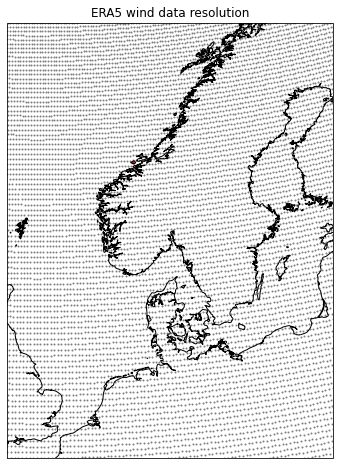

In [120]:
ds = xr.open_dataset("data/era5_atm_grid.grib")
lats=ds.coords.indexes["latitude"]
lons=ds.coords.indexes["longitude"]
xx,yy=np.meshgrid(lons,lats)
proj = cartopy.crs.AlbersEqualArea()
plt.figure(figsize=(8,8))
ax = plt.axes(projection=proj,extent=[-2, 20, 50, 70])
plt.title('ERA5 wind data resolution')
ax.coastlines(resolution='10m')
if isinstance(proj,cartopy.crs.PlateCarree): # grid lines only supported for PlateCarree
    gl = ax.gridlines(crs=proj, draw_labels=True,
        linewidth=1, color='gray', alpha=0.5, linestyle='-')
    gl.top_labels = False
    gl.left_labels = False
coords=np.outer(lats,lons)
plt.scatter(xx,yy,s=1,marker="o",color="gray",transform=cartopy.crs.Geodetic())
plt.scatter(locations2.loc["smøla","lon"],locations2.loc["smøla","lat"],s=3,marker="o",color="red",transform=cartopy.crs.Geodetic())
plt.show()

In [76]:
nve_vind=pd.read_excel("C:/Users/hsven/OneDrive - SINTEF/DATA/vind_nve/vindproduksjon_2002-2020_faktisk_produksjonutc-1.xlsx")

In [82]:
nve_vind = nve_vind.loc[2:]

In [86]:
nve_vind=nve_vind.set_index("kraftverknavn")
nve_vind.index.name="timestamp"

In [132]:
df["smøla"] = nve_vind.loc[nve_vind.index.year==2020,"Smøla"]/150.4

In [133]:
df.loc[df.index.year==2020]

u          v  wind_speed  wind_power     smøla
time                                                                       
2020-01-01 00:00:00  22.097458  10.750092   24.573606    0.111167  0.000000
2020-01-01 01:00:00  23.768463  12.426971   26.821064    0.000000  0.000000
2020-01-01 02:00:00  24.955109  12.939453   28.110264    0.000000  0.000000
2020-01-01 03:00:00  24.571518  12.954773   27.777431    0.000000  0.000000
2020-01-01 04:00:00  23.122437  13.542542   26.796410    0.000000  0.000000
...                        ...        ...         ...         ...       ...
2020-12-31 19:00:00  -4.209518  -2.901047    5.112349    0.053370  0.003098
2020-12-31 20:00:00  -3.766418  -2.484787    4.512214    0.035366  0.000000
2020-12-31 21:00:00  -3.368835  -2.229217    4.039612    0.021188  0.000751
2020-12-31 22:00:00  -4.766037  -1.521591    5.003034    0.050091  0.000000
2020-12-31 23:00:00  -4.217072  -0.273529    4.225933    0.026778  0.000000

[8784 rows x 5 columns]

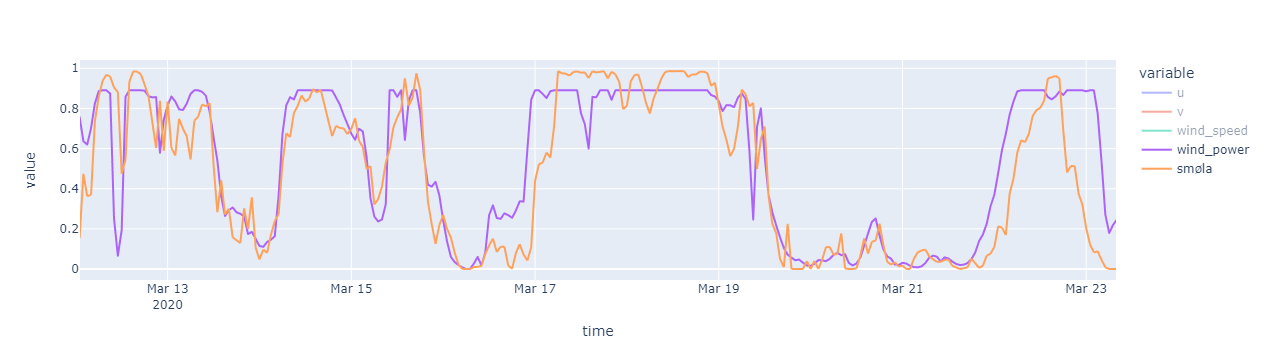

In [134]:
px.line(df)

In [ ]:
df.loc[df.index.year==2020].sum()